# iModulon Characterization:
# Initial Setup & Characterization from knowledge-bases

## Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

In [1]:
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

from pymodulon.core import IcaData
from pymodulon.plotting import *

In [2]:
# Enter the location of your data here
data_dir = '../data/'

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [3]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
SRX3467357,FadR,wt_p
SRX3467358,FadR,wt_p
SRX3467359,FadR,ko_p
SRX3467360,FadR,ko_p
SRX3565164,GDGT,75_2.4_log


In [4]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [5]:
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')
df_trn.head()

,regulator,regulator_id,gene_name,gene_id,old_locus_tag,prokka_locus_tag,synonyms,direction,evidence,PMID,additional_notes
0,BarR,SACI_RS10330,barR,SACI_RS10330,Saci_2136,Sacid_02134,NaN,NaN,qRT-PCR,24646198,BarR TF (Lrp/AsnC family transcriptional regul...
1,BarR,SACI_RS10330,spuC,SACI_RS10335,Saci_2137,Sacid_02135,NaN,+,qRT-PCR,24646198,NaN
2,BarR,SACI_RS10330,gltB_1,SACI_RS11230,Saci_2320,Sacid_02323,gltB,+,ChIP-Seq,27502941,NaN
3,BarR,SACI_RS10330,gltB_2,SACI_RS11235,Saci_2321,Sacid_02324,"gltB, purF_3",+,ChIP-Seq,27502941,NaN
4,LrpC,SACI_RS07575,lrpC,SACI_RS07575,Saci_1588,Sacid_01553,Sa-Lrp,NaN,"qRT-PCR, EMSA",23255531,Sa-Lrp TF (Lrp/AsnC family transcriptional reg...


The `regulator` and `gene_id` must be filled in for each row

In [6]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [7]:
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_Jan_07_2021.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

## Regulatory iModulons (from manually curated TRN file)
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.


* What is the TRN file?

The TRN file is a manually curated list of regulons from known transciptional regulators or genes known to perform a certain regulatory/functional role with a predicted but currently unidentified transcription factor.


In the case of Sulfolobus acidocaldarius, examples of known regulons include the Archaellum Regulatory Network and the FadR gene clusters

In [8]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,11,XylR,3.084629e-11,6.169258e-11,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0
1,12,YtrA,2.737665e-13,8.212996e-13,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0
2,13,LysM,9.072731e-10,9.072731e-10,0.400000,0.800000,0.533333,4.0,5.0,10.0,1.0
3,26,YtrA,9.564368e-06,9.564368e-06,0.428571,0.187500,0.260870,3.0,16.0,7.0,1.0
4,27,ArnR,8.720300e-21,1.744060e-20,1.000000,0.727273,0.842105,8.0,11.0,8.0,1.0
5,27,ArnR1,8.720300e-21,1.744060e-20,1.000000,0.727273,0.842105,8.0,11.0,8.0,1.0
6,27,ArnA,7.760893e-16,7.760893e-16,0.875000,0.466667,0.608696,7.0,15.0,8.0,1.0
7,27,ArnB,7.760893e-16,7.760893e-16,0.875000,0.466667,0.608696,7.0,15.0,8.0,1.0
8,29,FadR,1.349778e-37,1.349778e-37,0.760000,0.791667,0.775510,19.0,24.0,25.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #27 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

(This makes sense given that ArnR;ArnR1 are known activators while ArnA;ArnB are known repressors)

In [9]:
ica_data.compute_trn_enrichment(max_regs=4, save=True, force=True)

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,11,XylR,3.084629e-11,6.662798e-08,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0
1,11,YtrA/XylR,1.943583e-09,2.099070e-06,0.212766,0.256410,0.232558,10.0,39.0,47.0,2.0
2,12,YtrA,2.737665e-13,5.916095e-10,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0
3,12,YtrA/heat-shock,9.924763e-11,1.072371e-07,0.243243,0.333333,0.281250,9.0,27.0,37.0,2.0
4,12,FadR/YtrA,1.938626e-10,1.396457e-07,0.270270,0.250000,0.259740,10.0,40.0,37.0,2.0
5,12,FadR/YtrA/heat-shock,2.591737e-09,1.400186e-06,0.270270,0.196078,0.227273,10.0,51.0,37.0,3.0
6,13,LysM,9.072731e-10,1.958803e-06,0.400000,0.800000,0.533333,4.0,5.0,10.0,1.0
7,27,ArnR,8.720300e-21,4.713322e-18,1.000000,0.727273,0.842105,8.0,11.0,8.0,1.0
8,27,ArnR1,8.720300e-21,4.713322e-18,1.000000,0.727273,0.842105,8.0,11.0,8.0,1.0
9,27,ArnR+ArnR1,8.720300e-21,4.713322e-18,1.000000,0.727273,0.842105,8.0,11.0,8.0,2.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #27, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [10]:
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True)

pvalue           9.674248e-19
precision        8.750000e-01
recall           8.750000e-01
f1score          8.750000e-01
TP               7.000000e+00
regulon_size     8.000000e+00
imodulon_size    8.000000e+00
n_regs           4.000000e+00
Name: ArnR+ArnR1+ArnA+ArnB, dtype: float64

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [11]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
11,XylR,3.084629e-11,6.662798e-08,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0
12,YtrA,2.737665e-13,5.916095e-10,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0
13,LysM,9.072731e-10,1.958803e-06,0.400000,0.800000,0.533333,4.0,5.0,10.0,1.0
27,ArnR+ArnR1+ArnA+ArnB,9.674248e-19,4.713322e-18,0.875000,0.875000,0.875000,7.0,8.0,8.0,4.0
29,FadR,1.349778e-37,2.914171e-34,0.760000,0.791667,0.775510,19.0,24.0,25.0,1.0


In [12]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[10:28])

[10, 'XylR', 'YtrA', 'LysM', 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 'ArnR+ArnR1+ArnA+ArnB']


You can also manually rename iModulons with long names

In [13]:
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})

In [14]:
print(ica_data.imodulon_names[11], ica_data.imodulon_names[27])

XylR ArnRAB


## Functional iModulons

### GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [15]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,SACI_RS05325,glycerol kinase activity
1,SACI_RS05325,glycerol metabolic process
2,SACI_RS05525,maltose alpha-glucosidase activity
3,SACI_RS05590,protein binding
4,SACI_RS05600,identical protein binding


In [16]:
DF_GO.gene_id

0     SACI_RS05325
1     SACI_RS05325
2     SACI_RS05525
3     SACI_RS05590
4     SACI_RS05600
5     SACI_RS05610
6     SACI_RS08005
7     SACI_RS08005
8     SACI_RS09830
9     SACI_RS09830
10    SACI_RS10085
11    SACI_RS10085
12    SACI_RS10975
13    SACI_RS10975
14    SACI_RS10975
15    SACI_RS10980
16    SACI_RS10980
17    SACI_RS10980
18    SACI_RS10985
19    SACI_RS10985
20    SACI_RS10985
21    SACI_RS02915
22    SACI_RS00265
23    SACI_RS00265
24    SACI_RS00265
25    SACI_RS00265
26    SACI_RS00925
27    SACI_RS00925
28    SACI_RS00925
29    SACI_RS01090
30    SACI_RS01090
31    SACI_RS02225
32    SACI_RS10090
33    SACI_RS10090
34    SACI_RS00815
35    SACI_RS00815
Name: gene_id, dtype: object

In [17]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [18]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

### KEGG Enrichments

#### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [19]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
1045,SACI_RS00040,KEGG_pathway,map00760
1046,SACI_RS00040,KEGG_pathway,map01100
1048,SACI_RS00060,KEGG_pathway,map00230
1050,SACI_RS00070,KEGG_pathway,map03410
1055,SACI_RS00085,KEGG_pathway,map00361


In [20]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

#### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [21]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [22]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0


In [23]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,M00125,5.693334e-06,9.678668e-04,0.333333,1.000000,0.500000,2.0,2.0,6.0
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0


#### Convert KEGG IDs to human-readable names

In [24]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [25]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0,Monobactam biosynthesis


In [26]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,5.693334e-06,9.678668e-04,0.333333,1.000000,0.500000,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."


#### Save files

In [27]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_module_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

In [28]:
# Custom function (will be useful for characterizing iModulons)
def get_kegg_enrichments(imodulon, kegg_type):
    if kegg_type == 'pathway':
        df = DF_pathway_enrich
    elif kegg_type == 'module':
        df = DF_module_enrich
    else:
        raise ValueError('kegg_type must be either "pathway" or "module"')
    
    cond = df['imodulon'] == imodulon
    return df[cond].dropna()

## Check for single gene iModulons

In [29]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [30]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [31]:
for name in ica_data.imodulon_names:
    if not isinstance(name, int) and 'single_gene' in name:
        print(name)

single_gene_1
single_gene_2
single_gene_3
single_gene_4
single_gene_5
single_gene_6


## Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

In [32]:
from pymodulon.compare import *
from pymodulon.io import *

In [33]:
ecoli_data = load_json_model('../example_data/example.json')

In [34]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.3,
                         ortho_file = '../example_data/example_bbh.csv')
dots

[('GlpR', 'XylR', 0.3067430727683909),
 ('OxyR', 2, 0.3244159538646942),
 ('PurR-1', 10, 0.6533523554798278),
 ('CysB', 23, 0.6176360657152684),
 ('NtrC+RpoN', 38, 0.3907067688896175),
 ('Fur-2', 25, 0.4045954149766548),
 ('FadR/IclR', 'FadR', 0.39750691518554127)]

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

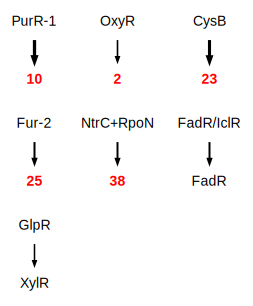

In [35]:
links

In [36]:
ica_data.imodulon_table['ecoli_ortholog'] = np.nan

for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

ica_data.imodulon_table.loc[[2, 10, 'XylR', 23, 25, 'FadR']]

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PurR-1
XylR,XylR,3.084629e-11,6.662798e-08,0.212766,0.370370,0.27027,10.0,27.0,47.0,1.0,NaN,GlpR
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,CysB
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fur-2
FadR,FadR,1.349778e-37,2.914171e-34,0.760000,0.791667,0.77551,19.0,24.0,25.0,1.0,NaN,FadR/IclR


### Visualize linked iModulons

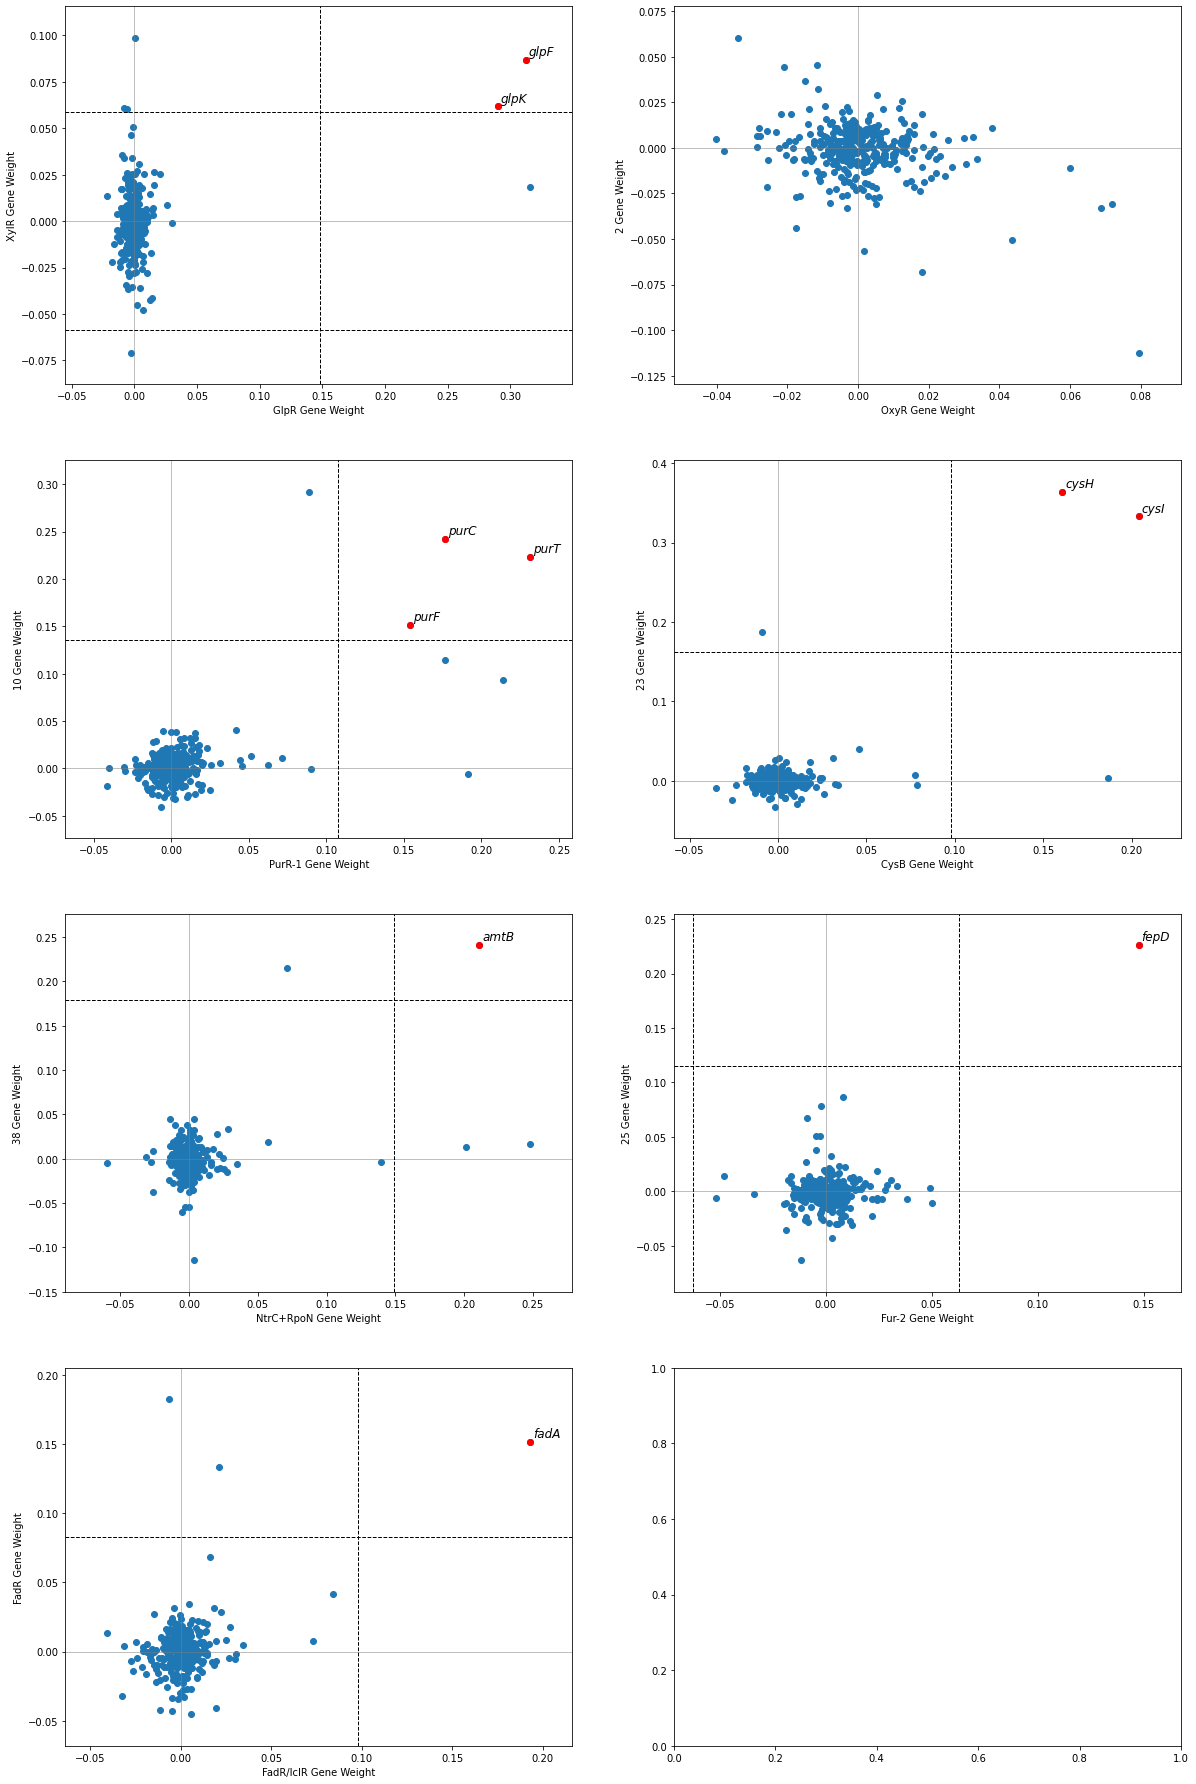

In [37]:
# Number of Rows:
num_rows = int(np.ceil(len(dots) / 2))

# Plot figures
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 8*num_rows))

counter = 0
for ecoli_mod,saci_mod,_ in dots:
    
    if counter % 2 == 0:
        r = int(counter / 2)
        c = 0
    else:
        r = int((counter - 1) / 2)
        c = 1
    
    compare_gene_weights(ica_data = ecoli_data,imodulon1=ecoli_mod,
                         ica_data2 = ica_data,imodulon2=saci_mod,
                         ortho_file ='../example_data/example_bbh.csv',
                         ax=axs[r, c])
    
    counter += 1

---

## Characterize Specified iModulons

### Known iModulons

These iModulons are fully characterized and match what is known in literature. In particular, ArnRAB, FadR, and FadR-KO iModulons can be used as literature-validation iModulons.

#### iModulon 27: ArnRAB

**The Archaellum Regulatory Network iModulon:**

Contains the Arn operon genes (Saci_1172 to Saci_1179). This operon, activated by ArnR/ArnR1 and repressed by ArnA/ArnB, is necessary for the generation of archaella, bacterial type-IV pili that function as flagella for this organism.

This iModulon differs from its regulons as it does not contain the transcription factors ArnR, ArnR1, ArnS, ArnA, ArnB and their phosphorylators ArnC, ArnD, Saci_pp2a, Saci_1208, and Saci_1209. This is partly expecter, however, as these TFs have been hypothesized to be regulated by something else (potentially UspA_Sa).

As expected from literature, this iModulon's activity increases during nutrient limitation conditions and is generally higher in the stationary phase vs log phase as archaella are used by Saci to move around and find food in their environment.

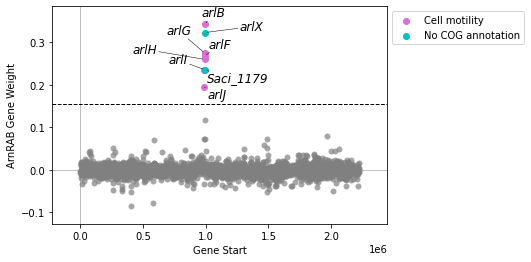

In [38]:
ax = plot_gene_weights(ica_data, 'ArnRAB')

#plt.savefig('../figures/ArnRAB_gene_weights.svg')

<AxesSubplot:ylabel='ArnRAB iModulon\nActivity'>

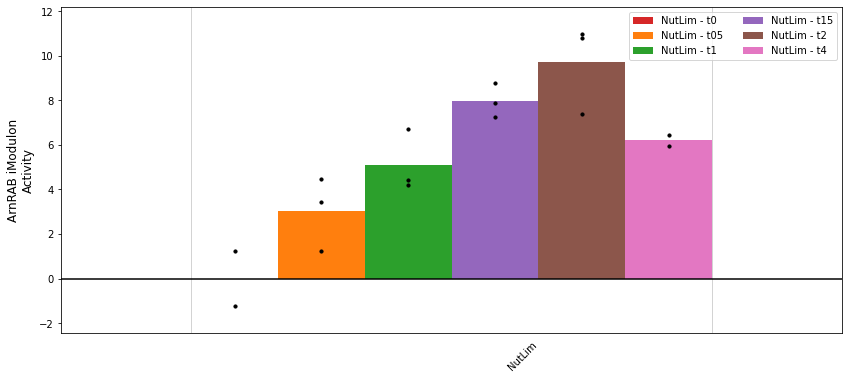

In [39]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'ArnRAB', projects='NutLim', highlight='NutLim', ax=ax)

#plt.savefig('../figures/ArnRAB_actv.svg')

#### iModulon 29: FadR  [E coli Ortholog: FadR/IclR]

**Fatty Acid Degradation Repressor iModulon**

Contains the FadR gene cluster, as well as a few other acyl-CoA ligases. Notably does not contain the fadR gene itself. FadR is a repressor that inhibits fatty acid breakdown genes from activating unless there is a high concentration of medium- to long-chain acyl-CoA in the cytosol.

This iModulon also does not contains 13 genes found in the regulon, many being hyrolases and short-chain-dehydrogenase oxidoreductases. This suggests that short-chain fatty acids may be regulated by another transcription factor. Additionally, the iModulon contains 6 genes that are not in the regulon, all of which are hypothetical proteins with little known about them.

The FadR iModulon has its highest activity in fadR deletion strains in both the `Chrom` and `FadR` projects, with the `NutLim` project being fairly high as well. This suggests that the iModulon is upregulated when the FadR gene cluster is actively expressed (i.e. high conc of med- and long-chain acyl-CoA or during nutrient limitation when fatty acids must be broken down as an alternative energy source).

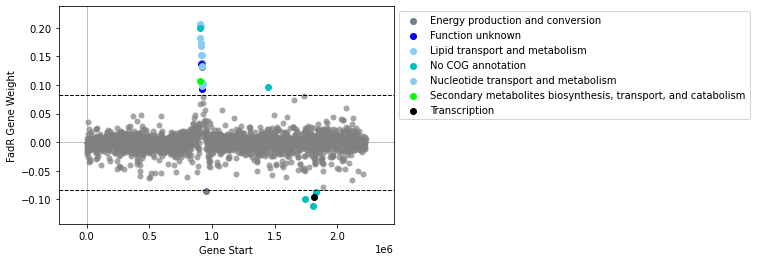

In [40]:
ax = plot_gene_weights(ica_data, 'FadR')

#plt.savefig('../figures/FadR_gene_weights.svg')

<AxesSubplot:ylabel='FadR iModulon\nActivity'>

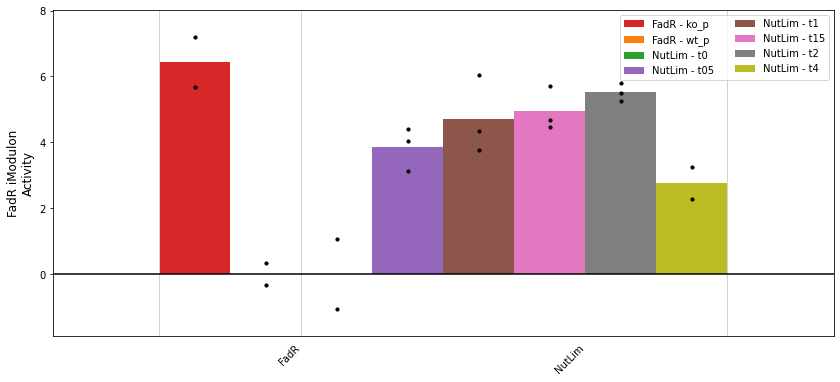

In [41]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'FadR', projects=['FadR', 'NutLim'], highlight=['Chrom', 'FadR', 'NutLim'], ax=ax)

#plt.savefig('../figures/FadR_actv.svg')

#### iModulon 24: FadR-KO iModulon (formerly single_gene_3)

**FadR TF iModulon**

Contains only 1 gene, __Saci_1107__, which codes for FadR

The activity of this iModulon is similar to the FadR iModulon, with the notable exception of the FadR-KO experiment having a substantially negative activity.

In [42]:
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

<AxesSubplot:xlabel='Gene Start', ylabel='FadR-KO Gene Weight'>

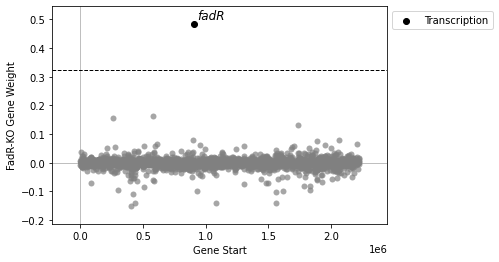

In [43]:
plot_gene_weights(ica_data, 'FadR-KO')

<AxesSubplot:ylabel='FadR-KO iModulon\nActivity'>

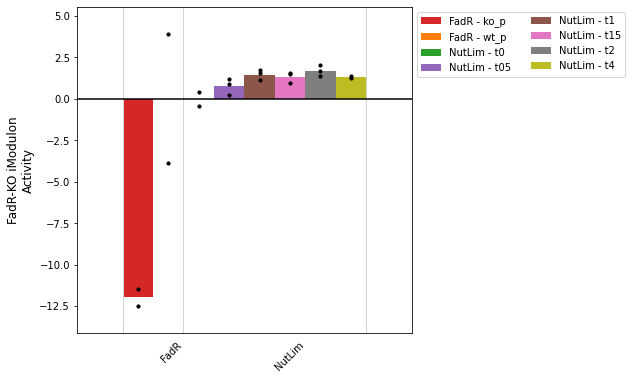

In [44]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_activities(ica_data, 'FadR-KO', projects=['FadR', 'NutLim'], highlight=['FadR', 'NutLim'], ax=ax)

### Regulon-matching iModulons

These iModulons match closely with a regulon from the manually curated TRN file (based on known literature) and were chosen via trn enrichment (See Regulatory-iModulons section)

#### iModulon 11: XylR-matching (Central-Carbon-Related) iModulon [E. coli ortholog: GlpR]

#### Putative Composite iModulon (Putative Glyerol Uptake (GlpR-like) + XylR +  SoxEFGHIM iModulon)
#### Putative Global Regulator for this iModulon

In [45]:
get_kegg_enrichments('XylR', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
16,XylR,map00072,0.000873,0.038839,0.063830,0.300000,0.105263,3.0,10.0,47.0,Synthesis and degradation of ketone bodies
17,XylR,map00310,0.000873,0.038839,0.063830,0.300000,0.105263,3.0,10.0,47.0,Lysine degradation
18,XylR,map00380,0.001183,0.038839,0.063830,0.272727,0.103448,3.0,11.0,47.0,Tryptophan metabolism
19,XylR,map00620,0.001113,0.038839,0.106383,0.125000,0.114943,5.0,40.0,47.0,Pyruvate metabolism
20,XylR,map00640,0.000385,0.038839,0.106383,0.156250,0.126582,5.0,32.0,47.0,Propanoate metabolism
21,XylR,map00720,0.000589,0.038839,0.127660,0.113208,0.120000,6.0,53.0,47.0,Carbon fixation pathways in prokaryotes
22,XylR,map00362,0.001555,0.043752,0.063830,0.250000,0.101695,3.0,12.0,47.0,Benzoate degradation
23,XylR,map02020,0.003079,0.075828,0.063830,0.200000,0.096774,3.0,15.0,47.0,Two-component system
24,XylR,map00900,0.003736,0.081772,0.063830,0.187500,0.095238,3.0,16.0,47.0,Terpenoid backbone biosynthesis


In [46]:
get_kegg_enrichments('XylR', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
14,XylR,M00088,0.000873,0.049459,0.063830,0.300000,0.105263,3.0,10.0,47.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."
15,XylR,M00373,0.000873,0.049459,0.063830,0.300000,0.105263,3.0,10.0,47.0,Ethylmalonyl pathway
16,XylR,M00416,0.000410,0.049459,0.042553,1.000000,0.081633,2.0,2.0,47.0,Cytochrome aa3-600 menaquinol oxidase
17,XylR,M00155,0.001215,0.051629,0.042553,0.666667,0.080000,2.0,3.0,47.0,"Cytochrome c oxidase, prokaryotes"
18,XylR,M00095,0.001992,0.062403,0.063830,0.230769,0.100000,3.0,13.0,47.0,"C5 isoprenoid biosynthesis, mevalonate pathway"
19,XylR,M00375,0.002202,0.062403,0.085106,0.142857,0.106667,4.0,28.0,47.0,Hydroxypropionate-hydroxybutylate cycle
20,XylR,M00374,0.003236,0.078580,0.085106,0.129032,0.102564,4.0,31.0,47.0,Dicarboxylate-hydroxybutyrate cycle


In [47]:
ica_data.rename_imodulons({'XylR': 'central-carbon-metabolism'})

<AxesSubplot:xlabel='Gene Start', ylabel='central-carbon-metabolism Gene Weight'>

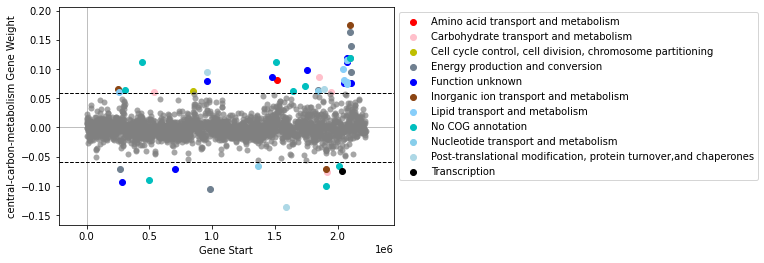

In [48]:
plot_gene_weights(ica_data, 'central-carbon-metabolism')

In [49]:
ica_data.view_imodulon('central-carbon-metabolism')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01445,0.066414,moaA_1,Saci_0296,Sacid_00292,NaN,251845.0,252864.0,-,PTO1314 family radical SAM protein,"GTP 3',8-cyclase",Inorganic ion transport and metabolism,A0A0U3H336,NC_007181.1,NaN
SACI_RS01495,0.060348,acsA_1,Saci_0306,Sacid_00302,acs,260644.0,262641.0,-,acetate--CoA ligase,Acetyl-coenzyme A synthetase,Lipid transport and metabolism,A0A0U3HAP5,NC_007181.1,NaN
SACI_RS01505,-0.071221,Saci_0308,Saci_0308,Sacid_00304,NaN,263557.0,263805.0,+,biotin attachment protein,hypothetical protein,Energy production and conversion,A0A0U2VW51,NC_007181.1,NaN
SACI_RS01585,-0.093007,Saci_0324,Saci_0324,Sacid_00320,NaN,277460.0,278311.0,-,sulfite exporter TauE/SafE family protein,putative membrane transporter protein,Function unknown,A0A0U2VW32,NC_007181.1,NaN
SACI_RS01760,0.063850,Saci_0360,Saci_0360,Sacid_00355,NaN,303121.0,304209.0,+,hypothetical protein,hypothetical protein,No COG annotation,M1ISI4,NC_007181.1,NaN
SACI_RS11800,0.111932,SACI_RS11800,NaN,NaN,NaN,442246.0,442317.0,-,hypothetical protein,NaN,No COG annotation,NaN,NC_007181.1,NaN
SACI_RS11555,-0.090678,SACI_RS11555,NaN,NaN,NaN,499991.0,500131.0,+,putative integrase,NaN,No COG annotation,UPI0011BFB8BC,NC_007181.1,NaN
SACI_RS03215,0.061065,abaF_1,Saci_0675,Sacid_00657,NaN,535612.0,536928.0,-,MFS transporter,Fosfomycin resistance protein AbaF,Carbohydrate transport and metabolism,A0A0U3FWX6,NC_007181.1,NaN
SACI_RS11610,-0.070474,Saci_0873,Saci_0873,Sacid_00851,NaN,700810.0,700977.0,-,YHS domain-containing protein,hypothetical protein,Function unknown,M1ITZ6,NC_007181.1,NaN
SACI_RS05015,0.061516,parA,Saci_1050,Sacid_01024,NaN,850873.0,852171.0,+,"ParA, chromosome-partioning ATPase, AAA family...",hypothetical protein,"Cell cycle control, cell division, chromosome ...",A0A0U2W2Y0,NC_007181.1,NaN


<AxesSubplot:ylabel='central-carbon-metabolism iModulon\nActivity'>

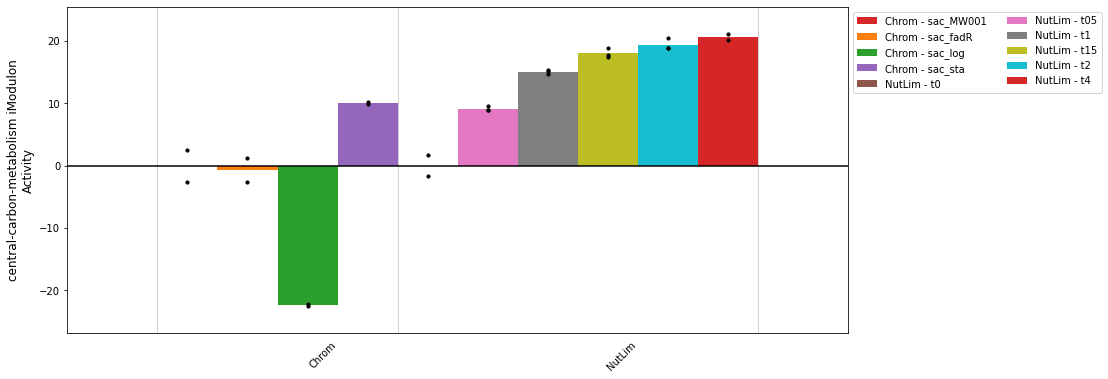

In [50]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'central-carbon-metabolism',
                projects=['Chrom', 'NutLim'],
                highlight=['Chrom', 'NutLim'],
                ax=ax)

#### iModulon 12: YtrA iModulon

#### Putative GTP/G-Protein-Coupled-Receptor / Metal Uptake iModulon 

<AxesSubplot:xlabel='Gene Start', ylabel='YtrA Gene Weight'>

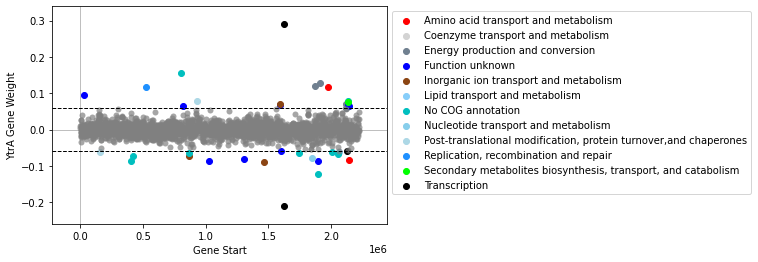

In [51]:
plot_gene_weights(ica_data, 'YtrA')

In [52]:
ica_data.view_imodulon('YtrA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS00195,0.094740,IMPDH_1,Saci_0044,Sacid_00042,NaN,29614.0,30108.0,+,CBS domain-containing protein,Inosine-5'-monophosphate dehydrogenase,Function unknown,A0A0U3GVE4,NC_007181.1,YtrA
SACI_RS00955,-0.061389,Saci_0198,Saci_0198,Sacid_00192,NaN,160314.0,162212.0,+,thioredoxin domain-containing protein,hypothetical protein,"Post-translational modification, protein turno...",A0A0U3FY45,NC_007181.1,NaN
SACI_RS02340,-0.087781,Saci_0484,Saci_0484,Sacid_00477,NaN,404875.0,405324.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U2X0E9,NC_007181.1,YtrA
SACI_RS02440,-0.073582,Saci_0506,Saci_0506,Sacid_00500,NaN,419872.0,420159.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FFQ9,NC_007181.1,NaN
SACI_RS03165,0.117220,Saci_0664,Saci_0664,Sacid_00646,NaN,526525.0,526800.0,-,hypothetical protein,hypothetical protein,"Replication, recombination and repair",A0A0U3FMW0,NC_007181.1,NaN
SACI_RS04795,0.156636,Saci_1004,Saci_1004,Sacid_00978,NaN,805226.0,805438.0,+,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FLQ2,NC_007181.1,NaN
SACI_RS04865,0.063848,Saci_1019,Saci_1019,Sacid_00992,NaN,818942.0,819370.0,+,small multi-drug export protein,hypothetical protein,Function unknown,A0A0U2XZL5,NC_007181.1,NaN
SACI_RS05085,-0.063764,Saci_1065,Saci_1065,Sacid_01041,NaN,869143.0,869940.0,+,ABC transporter permease,hypothetical protein,No COG annotation,A0A0U3GJ67,NC_007181.1,NaN
SACI_RS05090,-0.072732,btuD_6,Saci_1066,Sacid_01042,NaN,869942.0,870712.0,+,ATP-binding cassette domain-containing protein,Vitamin B12 import ATP-binding protein BtuD,Inorganic ion transport and metabolism,A0A0U3GK01,NC_007181.1,NaN
SACI_RS05365,0.078384,bcp_1,Saci_1125,Sacid_01101,NaN,929275.0,929751.0,-,peroxiredoxin,Putative peroxiredoxin,"Post-translational modification, protein turno...",A0A0U3GSS4,NC_007181.1,FadR


<AxesSubplot:ylabel='YtrA iModulon\nActivity'>

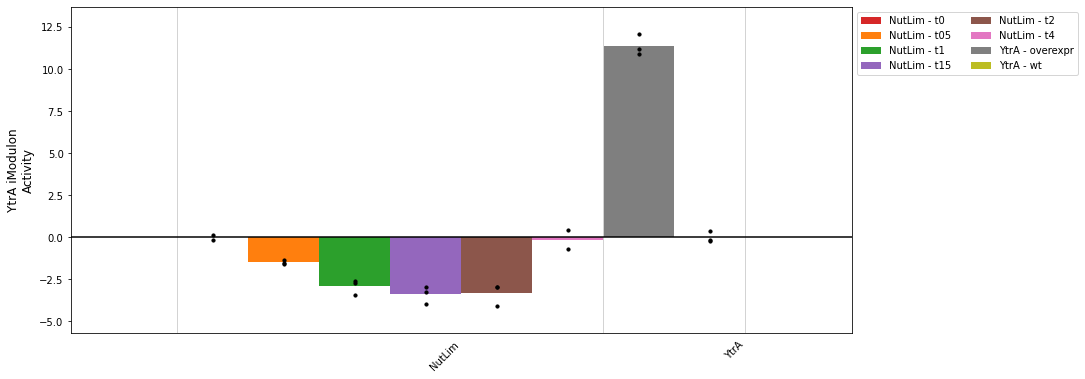

In [53]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'YtrA',
                projects=['NutLim', 'YtrA'],
                highlight=['NutLim', 'YtrA'],
                ax=ax)

#### iModulon 13: LysM iModulon (Lysine biosynthesis)

In [54]:
get_kegg_enrichments('LysM', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
25,LysM,map01210,2.320941e-10,4.572255e-08,0.6,0.230769,0.333333,6.0,26.0,10.0,2-Oxocarboxylic acid metabolism
26,LysM,map01230,4.638471e-07,4.568894e-05,0.6,0.068966,0.123711,6.0,87.0,10.0,Biosynthesis of amino acids
27,LysM,map00290,1.283633e-05,8.429188e-04,0.3,0.250000,0.272727,3.0,12.0,10.0,"Valine, leucine and isoleucine biosynthesis"
28,LysM,map00300,2.636557e-05,1.298504e-03,0.3,0.200000,0.240000,3.0,15.0,10.0,Lysine biosynthesis
29,LysM,map01100,2.963728e-04,1.167709e-02,0.7,0.017903,0.034913,7.0,391.0,10.0,Metabolic pathways
30,LysM,map00660,6.049418e-04,1.986226e-02,0.2,0.222222,0.210526,2.0,9.0,10.0,C5-Branched dibasic acid metabolism
31,LysM,map00220,1.298557e-03,3.654511e-02,0.2,0.153846,0.173913,2.0,13.0,10.0,Arginine biosynthesis
32,LysM,map00966,4.355401e-03,9.982140e-02,0.1,1.000000,0.181818,1.0,1.0,10.0,Glucosinolate biosynthesis
33,LysM,map01110,4.560368e-03,9.982140e-02,0.4,0.023121,0.043716,4.0,173.0,10.0,Biosynthesis of secondary metabolites


In [55]:
get_kegg_enrichments('LysM', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
21,LysM,M00031,6.324328e-09,0.000001,0.4,0.571429,0.470588,4.0,7.0,10.0,"Lysine biosynthesis, mediated by LysW, 2-amino..."
22,LysM,M00432,1.183116e-06,0.000067,0.3,0.500000,0.375000,3.0,6.0,10.0,"Leucine biosynthesis, 2-oxoisovalerate => 2-ox..."
23,LysM,M00763,1.183116e-06,0.000067,0.3,0.500000,0.375000,3.0,6.0,10.0,"Ornithine biosynthesis, mediated by LysW, glut..."
24,LysM,M00535,5.112088e-05,0.002173,0.2,0.666667,0.307692,2.0,3.0,10.0,"Isoleucine biosynthesis, pyruvate => 2-oxobuta..."


<AxesSubplot:xlabel='Gene Start', ylabel='LysM Gene Weight'>

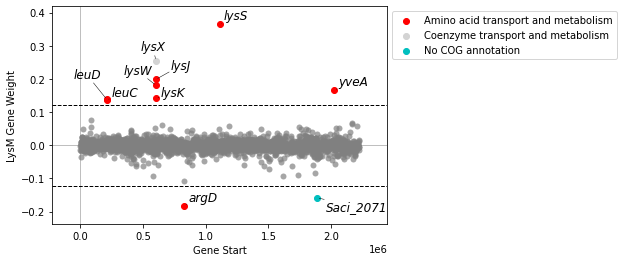

In [56]:
plot_gene_weights(ica_data, 'LysM')

In [57]:
ica_data.view_imodulon('LysM')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,refseq,regulator
SACI_RS01230,0.138002,leuD,Saci_0252,Sacid_00249,dmdB,211084.0,211569.0,-,3-isopropylmalate dehydratase small subunit,"2,3-dimethylmalate dehydratase small subunit",Amino acid transport and metabolism,A0A0U3H434,NC_007181.1,NaN
SACI_RS01235,0.136475,leuC,Saci_0253,Sacid_00250,NaN,211569.0,212813.0,-,3-isopropylmalate dehydratase large subunit,3-isopropylmalate dehydratase large subunit,Amino acid transport and metabolism,A0A0U3GWF6,NC_007181.1,NaN
SACI_RS03600,0.180626,lysW,Saci_0753,Sacid_00735,argW,602479.0,602649.0,+,Alpha-aminoadipate/glutamate carrier protein LysW,hypothetical protein,Amino acid transport and metabolism,A0A0U3HDS3,NC_007181.1,LysM
SACI_RS03605,0.255120,lysX,Saci_0754,Sacid_00736,lysX_1,602646.0,603503.0,+,Alpha-aminoadipate--LysW ligase LysX,Alpha-aminoadipate--LysW ligase LysX,Coenzyme transport and metabolism,A0A0U2WZV0,NC_007181.1,LysM
SACI_RS03610,0.198734,lysJ,Saci_0755,Sacid_00737,argD,603500.0,604663.0,+,[LysW]-aminoadipate semialdehyde/glutamate sem...,[LysW]-aminoadipate semialdehyde transaminase,Amino acid transport and metabolism,A0A0U2Y804,NC_007181.1,LysM
SACI_RS03615,0.141287,lysK,Saci_0756,Sacid_00738,NaN,604611.0,605651.0,+,[LysW]-lysine/[LysW]-ornithine hydrolase,[LysW]-lysine hydrolase,Amino acid transport and metabolism,A0A0U3F736,NC_007181.1,LysM
SACI_RS04910,-0.182192,argD,Saci_1028,Sacid_01002,NaN,827654.0,828943.0,+,acetyl ornithine aminotransferase family protein,Acetylornithine aminotransferase,Amino acid transport and metabolism,A0A0U3HA02,NC_007181.1,NaN
SACI_RS06235,0.364022,lysS,Saci_1304,Sacid_01280,NaN,1111101.0,1112507.0,-,homocitrate synthase,Homocitrate synthase,Amino acid transport and metabolism,UPI0000552583,NC_007181.1,NaN
SACI_RS11900,-0.158601,Saci_2071,Saci_2071,Sacid_02066,NaN,1888427.0,1888774.0,-,hypothetical protein,hypothetical protein,No COG annotation,A0A0U3FPY8,NC_007181.1,NaN
SACI_RS10580,0.166551,yveA,Saci_2189,Sacid_02188,NaN,2025549.0,2027396.0,-,APC family permease,Aspartate-proton symporter,Amino acid transport and metabolism,A0A0U3FGY1,NC_007181.1,NaN


In [58]:
ica_data.imodulon_table

,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## To be continued in next notebook